In [1]:
import time
import argparse
import numpy as np
import scipy.sparse as sp
import os
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from sklearn.metrics import mean_squared_error
from torch_geometric.data import Data

### 데이터셋

In [2]:
def load_pokec(dataset,sens_attr,predict_attr, path="./dataset/pokec/", label_number=1000,sens_number=500,seed=19,test_idx=False):
    """Load data"""
    print('Loading {} dataset from {}'.format(dataset,path))

    idx_features_labels = pd.read_csv(os.path.join(path,"{}.csv".format(dataset)))
    header = list(idx_features_labels.columns)
    header.remove("user_id")

    header.remove(sens_attr)
    header.remove(predict_attr)


    features = sp.csr_matrix(idx_features_labels[header], dtype=np.float32)
    labels = idx_features_labels[predict_attr].values
    

    # build graph
    idx = np.array(idx_features_labels["user_id"], dtype=int)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt(os.path.join(path,"{}_relationship.txt".format(dataset)), dtype=int)

    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=int).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)
    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    # features = normalize(features)
    adj = adj + sp.eye(adj.shape[0])

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(labels)
    # adj = sparse_mx_to_torch_sparse_tensor(adj)

    import random
    random.seed(seed)
    label_idx = np.where(labels>=0)[0]
    random.shuffle(label_idx)

    idx_train = label_idx[:min(int(0.5 * len(label_idx)),label_number)]
    idx_val = label_idx[int(0.5 * len(label_idx)):int(0.75 * len(label_idx))]
    if test_idx:
        idx_test = label_idx[label_number:]
        idx_val = idx_test
    else:
        idx_test = label_idx[int(0.75 * len(label_idx)):]




    sens = idx_features_labels[sens_attr].values

    sens_idx = set(np.where(sens >= 0)[0])
    idx_test = np.asarray(list(sens_idx & set(idx_test)))
    sens = torch.FloatTensor(sens)
    idx_sens_train = list(sens_idx - set(idx_val) - set(idx_test))
    random.seed(seed)
    random.shuffle(idx_sens_train)
    idx_sens_train = torch.LongTensor(idx_sens_train[:sens_number])


    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)
    

    # random.shuffle(sens_idx)

    return adj, features, labels, idx_train, idx_val, idx_test, sens,idx_sens_train

In [ ]:
df = pd.read_csv('/home/sypark/CIKM/dataset/pokec/region_job.csv')
df

In [ ]:
# 값 분포 확인
print("기초 통계량:")
print(df['completion_percentage'].describe())

# print("\n고유값 분포:")
# print(df['completion_percentage'].value_counts().sort_index())

# 히스토그램 시각화
plt.figure(figsize=(8, 4))
plt.hist(df['completion_percentage'], bins=30, edgecolor='black')
plt.title('Distribution of completion_percentage')
plt.xlabel('completion_percentage')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# Pokec 데이터 로딩
dataset = 'region_job'
sens_attr = 'region'
predict_attr = 'completion_percentage'

adj, features, labels, idx_train, idx_val, idx_test, sens, idx_sens_train = load_pokec(
    dataset, sens_attr, predict_attr
)

# PyG 형태로 변환
edge_index = torch.tensor(adj.nonzero(), dtype=torch.long)
data = Data(x=features, edge_index=edge_index, y=labels.float(), sensitive_attr=sens)
data.idx_train = idx_train
data.idx_val = idx_val
data.idx_test = idx_test

Loading region_job dataset from ./dataset/pokec/


/tmp/ipykernel_301281/1913178799.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  edge_index = torch.tensor(adj.nonzero(), dtype=torch.long)


In [3]:
def quantile_loss(y_true, y_pred, tau=0.9):
    error = y_true - y_pred
    return torch.mean(torch.max(tau * error, (tau - 1) * error))

@torch.no_grad()
def evaluate(model, data, idx_eval, tau=0.9):
    model.eval()
    if hasattr(model, 'fairness_loss') or hasattr(model, 'wasserstein_loss'):
        preds = model(data.x, data.edge_index, data.sensitive_attr)
    else:
        preds = model(data.x, data.edge_index)

    preds_eval = preds[idx_eval]
    sens_eval = data.sensitive_attr[idx_eval]

    g0 = preds_eval[sens_eval == 0]
    g1 = preds_eval[sens_eval == 1]

    if len(g0) == 0 or len(g1) == 0:
        fair_loss = None
    else:
        fair_loss = torch.abs(g0.mean() - g1.mean()).item()

    qr_loss = quantile_loss(data.y[idx_eval], preds_eval, tau).item()
    return qr_loss, fair_loss

def train_one_epoch(model, data, optimizer, tau=0.9):
    model.train()
    optimizer.zero_grad()

    if hasattr(model, 'fairness_loss') or hasattr(model, 'wasserstein_loss'):
        preds = model(data.x, data.edge_index, data.sensitive_attr)
    else:
        preds = model(data.x, data.edge_index)

    if hasattr(model, 'total_loss'):
        loss = model.total_loss(preds, data.y, data.sensitive_attr, tau)
    else:
        loss = quantile_loss(data.y[data.idx_train], preds[data.idx_train], tau)

    loss.backward()
    optimizer.step()
    return loss.item()

def run_experiment(model_class, data, device, tau=0.9, lambda_fair=None, n_epochs=100):
    if lambda_fair is not None:
        model = model_class(data.x.size(1), 64, lambda_fair=lambda_fair).to(device)
    else:
        model = model_class(data.x.size(1), 64).to(device)

    optimizer = Adam(model.parameters(), lr=0.01)

    data = data.to(device)
    data.sensitive_attr = data.sensitive_attr.to(device)

    best_val_qr = float('inf')
    best_model = None

    for epoch in range(1, n_epochs + 1):
        loss = train_one_epoch(model, data, optimizer, tau=tau)
        val_qr, val_fair = evaluate(model, data, data.idx_val, tau=tau)
        if val_qr < best_val_qr:
            best_val_qr = val_qr
            best_model = model.state_dict()

    model.load_state_dict(best_model)
    test_qr, test_fair = evaluate(model, data, data.idx_test, tau=tau)
    return test_qr, test_fair

def multi_run_experiment(model_class, data, device, n_runs=5, tau=0.9, lambda_fair=None):
    qr_losses = []
    fair_gaps = []

    for run in range(n_runs):
        qr, fair = run_experiment(model_class, data, device, tau=tau, lambda_fair=lambda_fair)
        qr_losses.append(qr)
        fair_gaps.append(fair)
        print(f"Run {run+1}/{n_runs} completed: QR Loss={qr:.4f}, Fairness Gap={fair:.4f}")

    return np.array(qr_losses), np.array(fair_gaps)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.optim import Adam

class PlainGNNRegression(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)  # 단일 회귀 출력

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        out = self.fc(x).squeeze(-1)  # [N] 형태
        return out

class FairGNNRegression(nn.Module):
    def __init__(self, in_dim, hidden_dim, lambda_fair=1.0):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
        self.lambda_fair = lambda_fair

    def forward(self, x, edge_index, sensitive):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        preds = self.fc(x).squeeze(-1)  # [N]
        return preds

    def fairness_loss(self, preds, sensitive):
        group0 = preds[sensitive == 0]
        group1 = preds[sensitive == 1]
        if len(group0) == 0 or len(group1) == 0:
            return torch.tensor(0.0, device=preds.device)
        return torch.abs(group0.mean() - group1.mean())

    def total_loss(self, preds, y_true, sensitive, tau=0.9):
        # 기본 quantile loss
        error = y_true - preds
        quantile_loss = torch.mean(torch.max(tau * error, (tau - 1) * error))

        # 공정성 정규화
        fair_loss = self.fairness_loss(preds, sensitive)

        return quantile_loss + self.lambda_fair * fair_loss


In [ ]:
# Bias-aware Message Passing + Distributional Fairness Loss
# 메세지 패싱할 때 민감속성(sensitive group)을 고려해서, 이웃으로부터 받을 때 그룹별 weight를 다르게 주거나, 아예 그룹별로 메세지를 분리해서 aggregate
# 또는 그룹별 center representation을 유지하면서 업데이트 단계에서 bias 방향을 제거
# 구조적 Fairness 통합 GNN

# 예측 분포 간 거리를 줄이는 Fairness Loss 도입

# DF-GNN(Distributional Fairness GNN)

In [9]:
class DistributionAwareFairGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, base_lambda=1.0, alpha=1.0, gamma=1.0):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)

        self.base_lambda = base_lambda
        self.alpha = alpha
        self.gamma = gamma

        self.device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')  
        
    def forward(self, x, edge_index, sensitive, return_hidden=False):
        h = F.relu(self.conv1(x, edge_index))
        h = F.relu(self.conv2(h, edge_index))
        preds = self.fc(h).squeeze(-1)

        if return_hidden:
            return preds, h
        else:
            return preds

    def compute_bias_score(self, h, sensitive):
        group0_center = h[sensitive == 0].mean(dim=0)
        group1_center = h[sensitive == 1].mean(dim=0)

        group_center = torch.where(sensitive.unsqueeze(-1) == 0, group0_center, group1_center)
        bias_score = (h - group_center).norm(p=2, dim=1)
        return bias_score

    def adaptive_projection(self, h, bias_score):
        adaptive_lambda = self.base_lambda * (1 + self.gamma * bias_score)
        h_norm = h.norm(p=2, dim=1, keepdim=True) + 1e-6
        scale = torch.min(torch.ones_like(adaptive_lambda).unsqueeze(-1), adaptive_lambda.unsqueeze(-1) / h_norm)
        h_projected = h * scale
        return h_projected

    def distribution_aware_fairness_loss(self, preds, sensitive):
        group0 = preds[sensitive == 0]
        group1 = preds[sensitive == 1]

        if len(group0) == 0 or len(group1) == 0:
            return torch.tensor(0.0, device=preds.device)

        mean_gap = torch.abs(group0.mean() - group1.mean())
        var_gap = torch.abs(group0.var(unbiased=False) - group1.var(unbiased=False))

        return mean_gap + self.alpha * var_gap

    def hierarchical_lambda(self, epoch, max_lambda=1.0, beta=0.05):
        epoch_tensor = torch.tensor(epoch, dtype=torch.float32, device=self.device)  # Tensor로 변환
        return max_lambda * (1 - torch.exp(-beta * epoch_tensor))

    def total_loss(self, preds, hidden, sensitive, y_true, epoch, tau=0.9):
        error = y_true - preds
        loss_qr = torch.mean(torch.max(tau * error, (tau - 1) * error))

        bias_score = self.compute_bias_score(hidden, sensitive)
        hidden_projected = self.adaptive_projection(hidden, bias_score)

        fair_loss = self.distribution_aware_fairness_loss(preds, sensitive)

        lambda_fair = self.hierarchical_lambda(epoch, max_lambda=self.base_lambda)

        return loss_qr + lambda_fair * fair_loss


In [10]:
# 데이터 로딩
dataset = 'region_job'
sens_attr = 'region'
predict_attr = 'completion_percentage'

adj, features, labels, idx_train, idx_val, idx_test, sens, idx_sens_train = load_pokec(
    dataset, sens_attr, predict_attr
)

# PyG 형태로 변환
edge_index = torch.tensor(adj.nonzero(), dtype=torch.long)
data = Data(x=features, edge_index=edge_index, y=labels.float(), sensitive_attr=sens)
data.idx_train = idx_train
data.idx_val = idx_val
data.idx_test = idx_test

# Device 설정
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
data.sensitive_attr = data.sensitive_attr.to(device)

model = DistributionAwareFairGNN(in_dim=data.x.size(1), hidden_dim=64).to(device)
optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


num_epochs = 500
for epoch in range(1, num_epochs + 1):
    model.train()

    preds, hidden = model(data.x, data.edge_index, data.sensitive_attr, return_hidden=True)

    loss = model.total_loss(
        preds[data.idx_train], hidden[data.idx_train],
        data.sensitive_attr[data.idx_train], data.y[data.idx_train],
        epoch, tau=0.9
    )

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0 or epoch == 1:
        print(f"[Epoch {epoch}] Loss: {loss.item():.4f}")


Loading region_job dataset from ./dataset/pokec/
[Epoch 1] Loss: 37.0170
[Epoch 20] Loss: 9.0544
[Epoch 40] Loss: 10.9009
[Epoch 60] Loss: 10.0261
[Epoch 80] Loss: 10.1182
[Epoch 100] Loss: 9.9636
[Epoch 120] Loss: 9.0798
[Epoch 140] Loss: 10.8297
[Epoch 160] Loss: 8.7891
[Epoch 180] Loss: 8.5735
[Epoch 200] Loss: 7.9827
[Epoch 220] Loss: 8.7718
[Epoch 240] Loss: 7.9043
[Epoch 260] Loss: 9.4233
[Epoch 280] Loss: 6.3626
[Epoch 300] Loss: 5.1632
[Epoch 320] Loss: 5.0392
[Epoch 340] Loss: 4.8488
[Epoch 360] Loss: 5.4965
[Epoch 380] Loss: 3.9907
[Epoch 400] Loss: 3.7511
[Epoch 420] Loss: 3.6997
[Epoch 440] Loss: 3.6308
[Epoch 460] Loss: 3.3586
[Epoch 480] Loss: 3.2641
[Epoch 500] Loss: 3.2009


In [12]:
@torch.no_grad()
def groupwise_evaluation(model, data, tau=0.9):
    model.eval()

    preds, _ = model(data.x, data.edge_index, data.sensitive_attr, return_hidden=True)

    preds = preds[data.idx_test]
    y_true = data.y[data.idx_test]
    sensitive = data.sensitive_attr[data.idx_test]

    # 전체 QR loss
    overall_qr = quantile_loss(y_true, preds, tau).item()

    # Group별 나누기
    preds_g0 = preds[sensitive == 0]
    preds_g1 = preds[sensitive == 1]
    y_true_g0 = y_true[sensitive == 0]
    y_true_g1 = y_true[sensitive == 1]

    # Group별 QR loss
    qr_loss_g0 = quantile_loss(y_true_g0, preds_g0, tau).item()
    qr_loss_g1 = quantile_loss(y_true_g1, preds_g1, tau).item()

    # Group별 예측 평균 (Fairness 측정용)
    mean_pred_g0 = preds_g0.mean().item()
    mean_pred_g1 = preds_g1.mean().item()
    fairness_gap = abs(mean_pred_g0 - mean_pred_g1)

    results = {
        'Overall QR Loss': overall_qr,
        'Group 0 QR Loss': qr_loss_g0,
        'Group 1 QR Loss': qr_loss_g1,
        'Fairness Gap (mean)': fairness_gap,
    }

    return results

In [16]:
results = groupwise_evaluation(model, data, tau=0.9)
df = pd.DataFrame([results])
df

,Overall QR Loss,Group 0 QR Loss,Group 1 QR Loss,Fairness Gap (mean)
0,3.192664,3.211973,3.157016,0.037605


In [34]:
from scipy.stats import wasserstein_distance

def quantile_loss(y_true, y_pred, tau=0.9):
    error = y_true - y_pred
    return torch.mean(torch.max(tau * error, (tau - 1) * error))

def train_one_epoch(model, data, optimizer, epoch, tau=0.9):
    model.train()
    optimizer.zero_grad()

    if isinstance(model, DistributionAwareFairGNN):
        preds, hidden = model(data.x, data.edge_index, data.sensitive_attr, return_hidden=True)
        loss = model.total_loss(preds[data.idx_train], hidden[data.idx_train], data.sensitive_attr[data.idx_train], data.y[data.idx_train], epoch, tau)
    elif isinstance(model, FairGNNRegression) or hasattr(model, 'fairness_loss'):
        preds = model(data.x, data.edge_index, data.sensitive_attr)
        loss = model.total_loss(preds[data.idx_train], data.y[data.idx_train], data.sensitive_attr[data.idx_train], tau)
    else:
        preds = model(data.x, data.edge_index)
        loss = quantile_loss(data.y[data.idx_train], preds[data.idx_train], tau)

    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate(model, data, tau=0.9):
    model.eval()

    if isinstance(model, (FairGNNRegression, DistributionAwareFairGNN)) or hasattr(model, 'fairness_loss'):
        preds = model(data.x, data.edge_index, data.sensitive_attr)
    else:
        preds = model(data.x, data.edge_index)

    preds = preds[data.idx_test]
    y_true = data.y[data.idx_test]
    sensitive = data.sensitive_attr[data.idx_test]

    qr_loss = quantile_loss(y_true, preds, tau).item()
    fairness_gap = abs(preds[sensitive == 0].mean() - preds[sensitive == 1].mean()).item()

    return qr_loss, fairness_gap

@torch.no_grad()
def evaluate_metrics(model, data, idx_eval, tau=0.9, threshold=0.5):
    model.eval()

    if isinstance(model, (FairGNNRegression, DistributionAwareFairGNN)):
        if isinstance(model, DistributionAwareFairGNN):
            preds, _ = model(data.x, data.edge_index, data.sensitive_attr, return_hidden=True)
        else:
            preds = model(data.x, data.edge_index, data.sensitive_attr)
    else:
        preds = model(data.x, data.edge_index)

    preds = preds[idx_eval].cpu()
    y_true = data.y[idx_eval].cpu()
    sensitive = data.sensitive_attr[idx_eval].cpu()

    error = y_true - preds
    qr_loss = torch.mean(torch.max(tau * error, (tau - 1) * error)).item()
    mae = torch.mean(torch.abs(error)).item()
    rmse = torch.sqrt(torch.mean(error ** 2)).item()
    r2 = 1 - torch.sum(error ** 2) / torch.sum((y_true - y_true.mean()) ** 2)

    group0 = preds[sensitive == 0]
    group1 = preds[sensitive == 1]
    fair_gap = torch.abs(group0.mean() - group1.mean()).item()

    results = {
        'QR Loss': qr_loss,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2.item(),
        'Fairness Gap': fair_gap
    }

    return results

def run_experiment(model_class, data, device, n_epochs=300, tau=0.9, lambda_fair=None):
    if model_class.__name__ == 'FairGNNRegression':
        model = model_class(data.x.size(1), 64, lambda_fair=lambda_fair).to(device)
    else:
        model = model_class(data.x.size(1), 64).to(device)

    optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    best_val_qr = float('inf')
    best_model = None

    for epoch in range(1, n_epochs + 1):
        train_one_epoch(model, data, optimizer, epoch, tau)

        if epoch % 50 == 0 or epoch == n_epochs:
            val_qr, val_fair = evaluate(model, data, tau)
            print(f"[{model_class.__name__}] Epoch {epoch}: Val QR Loss={val_qr:.4f}, Fairness Gap={val_fair:.4f}")

    test_qr, test_fair = evaluate(model, data, tau)
    return test_qr, test_fair

In [22]:
data = data.to(device)
data.sensitive_attr = data.sensitive_attr.to(device)
results = []

# 1. Plain GNN
plain_qr, plain_fair = run_experiment(PlainGNNRegression, data, device)

results.append({
    'Model': 'PlainGNN',
    'QR Loss': plain_qr,
    'Fairness Gap': plain_fair,
})

# 2. Fair GNN
fair_qr, fair_fair = run_experiment(FairGNNRegression, data, device, lambda_fair=1.0)

results.append({
    'Model': 'FairGNN',
    'QR Loss': fair_qr,
    'Fairness Gap': fair_fair,
})

# 3. Distribution-aware FairGNN
dist_qr, dist_fair = run_experiment(DistributionAwareFairGNN, data, device)

results.append({
    'Model': 'DistributionAwareFairGNN',
    'QR Loss': dist_qr,
    'Fairness Gap': dist_fair,
})

[PlainGNNRegression] Epoch 50: Val QR Loss=4.7157, Fairness Gap=3.7268
[PlainGNNRegression] Epoch 100: Val QR Loss=4.2344, Fairness Gap=5.1680
[PlainGNNRegression] Epoch 150: Val QR Loss=4.2692, Fairness Gap=4.7649
[PlainGNNRegression] Epoch 200: Val QR Loss=4.1790, Fairness Gap=4.5493
[PlainGNNRegression] Epoch 250: Val QR Loss=4.2653, Fairness Gap=4.1521
[PlainGNNRegression] Epoch 300: Val QR Loss=4.2726, Fairness Gap=3.7969
[FairGNNRegression] Epoch 50: Val QR Loss=5.2190, Fairness Gap=0.6398
[FairGNNRegression] Epoch 100: Val QR Loss=4.6652, Fairness Gap=0.2379
[FairGNNRegression] Epoch 150: Val QR Loss=4.4576, Fairness Gap=0.4988
[FairGNNRegression] Epoch 200: Val QR Loss=4.2802, Fairness Gap=0.6431
[FairGNNRegression] Epoch 250: Val QR Loss=4.0207, Fairness Gap=0.7848
[FairGNNRegression] Epoch 300: Val QR Loss=3.7582, Fairness Gap=0.8020
[DistributionAwareFairGNN] Epoch 50: Val QR Loss=6.8584, Fairness Gap=2.6992
[DistributionAwareFairGNN] Epoch 100: Val QR Loss=5.7198, Fairness 

In [23]:
df_results = pd.DataFrame(results)
df_results

,Model,QR Loss,Fairness Gap
0,PlainGNN,4.272641,3.796932
1,FairGNN,3.758160,0.801971
2,DistributionAwareFairGNN,4.400931,1.581944


In [35]:
def multiple_runs_with_full_metrics(model_class, data, device, n_runs=5, n_epochs=300, tau=0.9, lambda_fair=None, threshold=0.8):
    all_metrics = []

    for run in range(n_runs):
        print(f"\n--- Run {run+1}/{n_runs} ---")
        model = train_model(model_class, data, device, n_epochs=n_epochs, tau=tau, lambda_fair=lambda_fair)

        metrics = evaluate_metrics(model, data, idx_eval=data.idx_test, tau=tau, threshold=threshold)
        all_metrics.append(metrics)

    # 평균과 표준편차 계산
    metrics_mean = {k: np.mean([m[k] for m in all_metrics if m[k] is not None]) for k in all_metrics[0]}
    metrics_std = {k: np.std([m[k] for m in all_metrics if m[k] is not None]) for k in all_metrics[0]}

    results = {}
    for k in metrics_mean:
        results[f"{k} Mean"] = metrics_mean[k]
        results[f"{k} Std"] = metrics_std[k]

    return results

def train_model(model_class, data, device, n_epochs=300, tau=0.9, lambda_fair=None):
    if lambda_fair is not None:
        model = model_class(data.x.size(1), 64, lambda_fair=lambda_fair).to(device)
    else:
        model = model_class(data.x.size(1), 64).to(device)

    optimizer = Adam(model.parameters(), lr=0.01)

    data = data.to(device)
    data.sensitive_attr = data.sensitive_attr.to(device)

    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()

        if isinstance(model, DistributionAwareFairGNN):
            preds, hidden = model(data.x, data.edge_index, data.sensitive_attr, return_hidden=True)
            loss = model.total_loss(preds[data.idx_train], hidden[data.idx_train], data.sensitive_attr[data.idx_train], data.y[data.idx_train], epoch, tau)
        
        elif isinstance(model, FairGNNRegression):
            preds = model(data.x, data.edge_index, data.sensitive_attr)
            loss = model.total_loss(preds[data.idx_train], data.y[data.idx_train], data.sensitive_attr[data.idx_train], tau)
        
        else:  # PlainGNN
            preds = model(data.x, data.edge_index)
            loss = quantile_loss(data.y[data.idx_train], preds[data.idx_train], tau)

        loss.backward()
        optimizer.step()

    return model


In [36]:
data = data.to(device)
data.sensitive_attr = data.sensitive_attr.to(device)
all_results = []

# 1. PlainGNN
plain_results = multiple_runs_with_full_metrics(PlainGNNRegression, data, device, n_runs=5)
plain_results['Model'] = 'PlainGNN'
all_results.append(plain_results)

# 2. FairGNN
fair_results = multiple_runs_with_full_metrics(FairGNNRegression, data, device, n_runs=5, lambda_fair=1.0)
fair_results['Model'] = 'FairGNN'
all_results.append(fair_results)

# 3. DistributionAwareFairGNN
dist_results = multiple_runs_with_full_metrics(DistributionAwareFairGNN, data, device, n_runs=5)
dist_results['Model'] = 'DistributionAwareFairGNN'
all_results.append(dist_results)


--- Run 1/5 ---

--- Run 2/5 ---

--- Run 3/5 ---

--- Run 4/5 ---

--- Run 5/5 ---

--- Run 1/5 ---

--- Run 2/5 ---

--- Run 3/5 ---

--- Run 4/5 ---

--- Run 5/5 ---

--- Run 1/5 ---

--- Run 2/5 ---

--- Run 3/5 ---

--- Run 4/5 ---

--- Run 5/5 ---


In [37]:
# 데이터프레임으로 보기
results_df = pd.DataFrame(all_results)
results_df

,QR Loss Mean,QR Loss Std,MAE Mean,MAE Std,RMSE Mean,RMSE Std,R2 Mean,R2 Std,Fairness Gap Mean,Fairness Gap Std,Model
0,4.255810,0.196626,25.440150,2.078722,33.897952,2.307707,-0.995604,0.275312,3.918945,0.348172,PlainGNN
1,4.016666,0.027955,29.392048,0.895185,38.193172,1.015328,-1.523466,0.134814,0.777336,0.069462,FairGNN
2,4.178719,0.114124,25.351872,0.456184,31.881808,0.491705,-0.757553,0.054131,0.395247,0.168699,DistributionAwareFairGNN


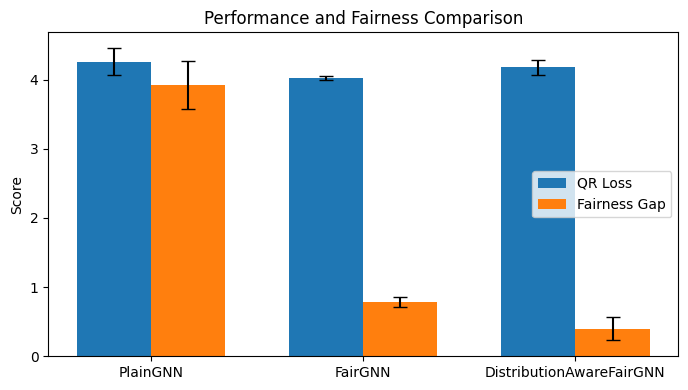

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터
models = ['PlainGNN', 'FairGNN', 'DistributionAwareFairGNN']
qr_means = [4.26, 4.02, 4.18]
qr_stds = [0.20, 0.03, 0.11]
fair_means = [3.92, 0.78, 0.40]
fair_stds = [0.35, 0.07, 0.17]

x = np.arange(len(models))
width = 0.35

# Plot
fig, ax1 = plt.subplots(figsize=(7,4))

ax1.bar(x - width/2, qr_means, width, yerr=qr_stds, capsize=5, label='QR Loss')
ax1.bar(x + width/2, fair_means, width, yerr=fair_stds, capsize=5, label='Fairness Gap')

ax1.set_ylabel('Score')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.set_title('Performance and Fairness Comparison')

plt.tight_layout()
plt.show()

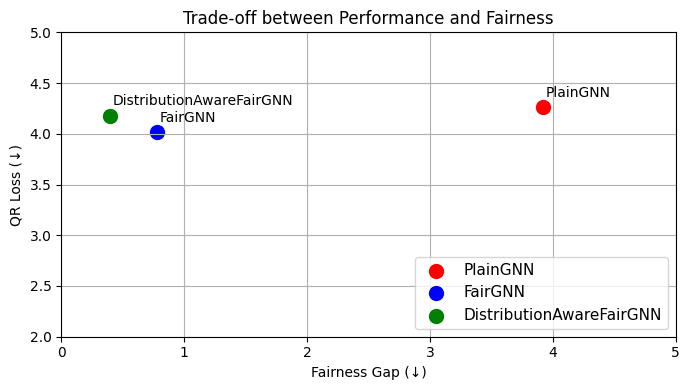

In [63]:
models = ['PlainGNN', 'FairGNN', 'DistributionAwareFairGNN']
qr_means = [4.26, 4.02, 4.18]
fair_means = [3.92, 0.78, 0.40]

colors = ['red', 'blue', 'green']

plt.figure(figsize=(7,4))

for i in range(len(models)):
    plt.scatter(fair_means[i], qr_means[i], color=colors[i], label=models[i], s=100)

# 라벨 추가
for i in range(len(models)):
    plt.text(fair_means[i]+0.02, qr_means[i]+0.1, models[i], fontsize=10)

plt.ylabel('QR Loss (↓)')
plt.xlabel('Fairness Gap (↓)')
plt.ylim(2, 5)
plt.xlim(0, 5)
plt.title('Trade-off between Performance and Fairness')
plt.grid(True)
plt.legend(loc='lower right', fontsize = 11)
plt.tight_layout()
plt.show()


In [70]:
# Trade-off 실험
lambdas = [0.0, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]
results = []

for lambda_fair in lambdas:
    print(f"\n=== Lambda {lambda_fair} ===")
    fair_results = multiple_runs_with_full_metrics(FairGNNRegression, data, device, n_runs=5, lambda_fair=lambda_fair)
    fair_results['Lambda'] = lambda_fair
    results.append(fair_results)

df_lambda = pd.DataFrame(results)
print(df_lambda[['Lambda', 'QR Loss Mean', 'Fairness Gap Mean']])


=== Lambda 0.0 ===

--- Run 1/5 ---

--- Run 2/5 ---

--- Run 3/5 ---

--- Run 4/5 ---

--- Run 5/5 ---

=== Lambda 0.01 ===

--- Run 1/5 ---

--- Run 2/5 ---

--- Run 3/5 ---

--- Run 4/5 ---

--- Run 5/5 ---

=== Lambda 0.05 ===

--- Run 1/5 ---

--- Run 2/5 ---

--- Run 3/5 ---

--- Run 4/5 ---

--- Run 5/5 ---

=== Lambda 0.1 ===

--- Run 1/5 ---

--- Run 2/5 ---

--- Run 3/5 ---

--- Run 4/5 ---

--- Run 5/5 ---

=== Lambda 0.5 ===

--- Run 1/5 ---

--- Run 2/5 ---

--- Run 3/5 ---

--- Run 4/5 ---

--- Run 5/5 ---

=== Lambda 1.0 ===

--- Run 1/5 ---

--- Run 2/5 ---

--- Run 3/5 ---

--- Run 4/5 ---

--- Run 5/5 ---

=== Lambda 5.0 ===

--- Run 1/5 ---

--- Run 2/5 ---

--- Run 3/5 ---

--- Run 4/5 ---

--- Run 5/5 ---

=== Lambda 10.0 ===

--- Run 1/5 ---

--- Run 2/5 ---

--- Run 3/5 ---

--- Run 4/5 ---

--- Run 5/5 ---
   Lambda  QR Loss Mean  Fairness Gap Mean
0    0.00      4.327622           3.863727
1    0.01      4.291384           1.659421
2    0.05      4.259816     

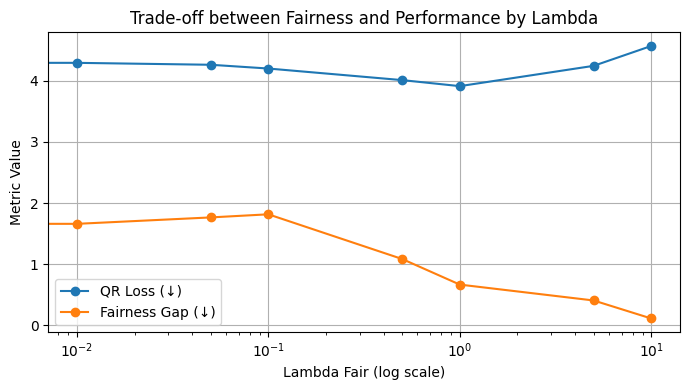

In [73]:
plt.figure(figsize=(7,4))
plt.plot(df_lambda['Lambda'], df_lambda['QR Loss Mean'], marker='o', label='QR Loss (↓)')
plt.plot(df_lambda['Lambda'], df_lambda['Fairness Gap Mean'], marker='o', label='Fairness Gap (↓)')

plt.xscale('log')  # λ는 보통 로그스케일로 표현
plt.xlabel('Lambda Fair (log scale)')
plt.ylabel('Metric Value')
plt.title('Trade-off between Fairness and Performance by Lambda')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [79]:
# Ablation 실험
class DistributionAwareFairGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, lambda_fair=1.0, use_projection=True, use_fairness=True):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)

        self.base_lambda = lambda_fair
        self.gamma = 1.0

        self.use_projection = use_projection
        self.use_fairness = use_fairness

    def forward(self, x, edge_index, sensitive, return_hidden=False):
        x = F.relu(self.conv1(x, edge_index))
        h = F.relu(self.conv2(x, edge_index))
        preds = self.fc(h).squeeze(-1)

        if return_hidden:
            return preds, h
        else:
            return preds

    def quantile_loss(self, y_true, y_pred, tau=0.9):
        error = y_true - y_pred
        return torch.mean(torch.max(tau * error, (tau - 1) * error))

    def distribution_aware_fairness_loss(self, preds, sensitive):
        g0 = preds[sensitive == 0]
        g1 = preds[sensitive == 1]
        if len(g0) == 0 or len(g1) == 0:
            return torch.tensor(0.0, device=preds.device)
        return torch.abs(g0.mean() - g1.mean())

    def compute_bias_score(self, hidden, sensitive):
        g0 = hidden[sensitive == 0]
        g1 = hidden[sensitive == 1]
        bias = torch.norm(g0.mean(dim=0) - g1.mean(dim=0), p=2)
        return bias

    def adaptive_projection(self, h, bias_score):
        h_norm = h.norm(p=2, dim=1, keepdim=True) + 1e-6
        adaptive_lambda = self.base_lambda * (1 + self.gamma * bias_score)
        scale = torch.min(torch.ones_like(h_norm), adaptive_lambda.unsqueeze(-1) / h_norm)
        return h * scale

    def hierarchical_lambda(self, epoch, max_lambda=1.0, beta=0.05):
        device = next(self.parameters()).device  # 모델 파라미터의 디바이스 확인
        return max_lambda * (1 - torch.exp(-beta * torch.tensor(epoch, dtype=torch.float32, device=device)))

    def total_loss(self, preds, hidden, sensitive, y_true, epoch, tau=0.9):
        loss_qr = self.quantile_loss(y_true, preds)

        # Projection
        if self.use_projection:
            bias_score = self.compute_bias_score(hidden, sensitive)
            hidden = self.adaptive_projection(hidden, bias_score)

        # Fairness
        fair_loss = self.distribution_aware_fairness_loss(preds, sensitive) if self.use_fairness else torch.tensor(0.0, device=preds.device)

        lambda_fair = self.hierarchical_lambda(epoch, max_lambda=self.base_lambda)

        return loss_qr + lambda_fair * fair_loss

def ablation_train(model_class, data, device, n_epochs=300, tau=0.9, lambda_fair=1.0,
                   use_projection=True, use_fairness=True):
    model = model_class(data.x.size(1), 64, use_projection=use_projection, use_fairness=use_fairness, lambda_fair=lambda_fair).to(device)
    optimizer = Adam(model.parameters(), lr=0.01)

    for epoch in range(1, n_epochs + 1):
        model.train()
        preds, hidden = model(data.x, data.edge_index, data.sensitive_attr, return_hidden=True)
        loss = model.total_loss(preds[data.idx_train], hidden[data.idx_train], data.sensitive_attr[data.idx_train], data.y[data.idx_train], epoch, tau)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return model

@torch.no_grad()
def ablation_evaluate(model, data, idx_eval, tau=0.9):
    model.eval()
    preds = model(data.x, data.edge_index, data.sensitive_attr)
    preds = preds[idx_eval]
    y_true = data.y[idx_eval]
    sensitive = data.sensitive_attr[idx_eval]

    error = y_true - preds
    qr_loss = torch.mean(torch.max(tau * error, (tau - 1) * error)).item()

    g0 = preds[sensitive == 0]
    g1 = preds[sensitive == 1]
    fair_gap = abs(g0.mean() - g1.mean()).item()

    return qr_loss, fair_gap

def run_ablation_experiments(data, device, n_runs=5):
    results = []
    settings = [
        ("Full", True, True),
        ("w/o Projection", False, True),
        ("w/o Fairness", True, False),
        ("w/o Both", False, False)
    ]

    for setting_name, use_proj, use_fair in settings:
        qr_losses = []
        fair_gaps = []

        for run in range(n_runs):
            print(f"\n[{setting_name}] Run {run+1}/{n_runs}")
            model = ablation_train(DistributionAwareFairGNN, data, device,
                                   use_projection=use_proj, use_fairness=use_fair)
            qr, fair = ablation_evaluate(model, data, data.idx_test)
            qr_losses.append(qr)
            fair_gaps.append(fair)

        results.append({
            "Setting": setting_name,
            "QR Loss Mean": np.mean(qr_losses),
            "QR Loss Std": np.std(qr_losses),
            "Fairness Gap Mean": np.mean(fair_gaps),
            "Fairness Gap Std": np.std(fair_gaps)
        })

    return pd.DataFrame(results)

def plot_ablation(df_ablation):
    x = np.arange(len(df_ablation))
    width = 0.35

    fig, ax1 = plt.subplots(figsize=(7,4))

    ax1.bar(x - width/2, df_ablation['QR Loss Mean'], width, yerr=df_ablation['QR Loss Std'], label='QR Loss')
    ax1.bar(x + width/2, df_ablation['Fairness Gap Mean'], width, yerr=df_ablation['Fairness Gap Std'], label='Fairness Gap')

    ax1.set_ylabel('Metric Value')
    ax1.set_title('Ablation Study: QR Loss vs Fairness Gap')
    ax1.set_xticks(x)
    ax1.set_xticklabels(df_ablation['Setting'])
    ax1.legend()
    ax1.grid(True)

    plt.tight_layout()
    plt.show()

In [77]:
df_ablation = run_ablation_experiments(data, device, n_runs=5)
print(df_ablation)


[Full] Run 1/5

[Full] Run 2/5

[Full] Run 3/5

[Full] Run 4/5

[Full] Run 5/5

[w/o Projection] Run 1/5

[w/o Projection] Run 2/5

[w/o Projection] Run 3/5

[w/o Projection] Run 4/5

[w/o Projection] Run 5/5

[w/o Fairness] Run 1/5

[w/o Fairness] Run 2/5

[w/o Fairness] Run 3/5

[w/o Fairness] Run 4/5

[w/o Fairness] Run 5/5

[w/o Both] Run 1/5

[w/o Both] Run 2/5

[w/o Both] Run 3/5

[w/o Both] Run 4/5

[w/o Both] Run 5/5
          Setting  QR Loss Mean  QR Loss Std  Fairness Gap Mean  \
0            Full      4.006350     0.071820           0.812186   
1  w/o Projection      4.083440     0.015313           0.837840   
2    w/o Fairness      4.256118     0.136111           4.188406   
3        w/o Both      4.276340     0.164976           3.498381   

   Fairness Gap Std  
0          0.135323  
1          0.044192  
2          0.374150  
3          0.185986  


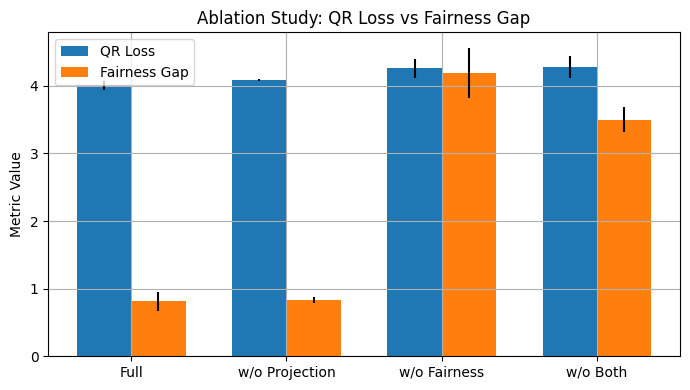

In [80]:
plot_ablation(df_ablation)

## U-FMPQ

In [30]:
class GroupAwareGNNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.mlp0 = nn.Linear(in_dim, out_dim)
        self.mlp1 = nn.Linear(in_dim, out_dim)

    def forward(self, x, edge_index, sensitive):
        m0 = torch.zeros_like(x)
        m1 = torch.zeros_like(x)

        src, dst = edge_index
        s_src = sensitive[src]

        mask0 = (s_src == 0)
        m0.index_add_(0, dst[mask0], x[src[mask0]])

        mask1 = (s_src == 1)
        m1.index_add_(0, dst[mask1], x[src[mask1]])

        h0 = self.mlp0(m0)
        h1 = self.mlp1(m1)
        
        return h0 + h1

class U_FMPQ(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.layer1 = GroupAwareGNNLayer(in_dim, hidden_dim)
        self.act = nn.ReLU()
        self.out_layer = nn.Linear(hidden_dim, 1)

    def forward(self, x, edge_index, sensitive):
        h = self.layer1(x, edge_index, sensitive)
        h = self.act(h)
        q_tau = self.out_layer(h).squeeze(-1)  # [N]
        return q_tau

def quantile_loss(y_true, y_pred, tau):
    error = y_true - y_pred
    return torch.mean(torch.max(tau * error, (tau - 1) * error))

def fairness_regularizer(preds, sensitive):
    g0 = preds[sensitive == 0]
    g1 = preds[sensitive == 1]
    if len(g0) == 0 or len(g1) == 0:
        return torch.tensor(0.0, device=preds.device)
    return torch.abs(torch.mean(g0) - torch.mean(g1))

from scipy.stats import wasserstein_distance

def wasserstein_regularizer(preds, sensitive):
    g0 = preds[sensitive == 0].detach().cpu().numpy()
    g1 = preds[sensitive == 1].detach().cpu().numpy()
    return torch.tensor(wasserstein_distance(g0, g1), device=preds.device)

In [31]:
def train_one_epoch(model, data, idx_train, optimizer, tau=0.9, lambda_fair=1.0):
    model.train()
    optimizer.zero_grad()

    preds = model(data.x, data.edge_index, data.sensitive_attr)
    y_true = data.y

    loss_qr = quantile_loss(y_true[idx_train], preds[idx_train], tau)
    loss_fair = wasserstein_regularizer(preds[idx_train], data.sensitive_attr[idx_train]) # 속성별
    loss = loss_qr + lambda_fair * loss_fair

    loss.backward()
    optimizer.step()
    return loss.item(), loss_qr.item(), loss_fair.item()

@torch.no_grad()
def evaluate(model, data, idx_eval, tau=0.9):
    model.eval()
    preds = model(data.x, data.edge_index, data.sensitive_attr)
    y_true = data.y

    loss_qr = quantile_loss(y_true[idx_eval], preds[idx_eval], tau)
    loss_fair = fairness_regularizer(preds[idx_eval], data.sensitive_attr[idx_eval])
    return preds, y_true, loss_qr.item(), loss_fair.item()


In [32]:
in_dim = data.x.size(1)
hidden_dim = 64
tau = 0.9
lambda_fair = 1.0

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

model = U_FMPQ(in_dim, hidden_dim).to(device)
data = data.to(device)
data.sensitive_attr = data.sensitive_attr.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, 101):
    total_loss, qr_loss, fair_loss = train_one_epoch(
        model, data, data.idx_train, optimizer, tau=tau, lambda_fair=lambda_fair
    )
    if epoch % 10 == 0:
        print(f"[Epoch {epoch}] Total: {total_loss:.4f}, QR: {qr_loss:.4f}, Fair: {fair_loss:.4f}")

# Test
preds, y_true, loss_qr, loss_fair = evaluate(model, data, data.idx_test, tau=tau)
print(f"\n[Test] QR Loss: {loss_qr:.4f}, Fairness Gap: {loss_fair:.4f}")


[Epoch 10] Total: 44.3957, QR: 15.4767, Fair: 28.9190
[Epoch 20] Total: 23.1480, QR: 13.4544, Fair: 9.6936
[Epoch 30] Total: 35.4795, QR: 12.7571, Fair: 22.7223
[Epoch 40] Total: 31.4794, QR: 12.2912, Fair: 19.1883
[Epoch 50] Total: 26.7776, QR: 11.8024, Fair: 14.9752
[Epoch 60] Total: 28.2545, QR: 11.1921, Fair: 17.0624
[Epoch 70] Total: 26.6094, QR: 10.3700, Fair: 16.2394
[Epoch 80] Total: 21.6977, QR: 9.4327, Fair: 12.2650
[Epoch 90] Total: 19.4961, QR: 8.5456, Fair: 10.9504
[Epoch 100] Total: 17.8101, QR: 7.7199, Fair: 10.0902

[Test] QR Loss: 9.6595, Fairness Gap: 7.4791


In [33]:
results = []

for lambda_fair in [0.0, 0.01, 0.1, 1.0, 10.0]:
    print(f"\n=== Lambda Fair = {lambda_fair} ===")

    model = U_FMPQ(in_dim, hidden_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(1, 101):
        total_loss, qr_loss, fair_loss = train_one_epoch(
            model, data, data.idx_train, optimizer, tau=tau, lambda_fair=lambda_fair
        )
        if epoch % 20 == 0:
            print(f"[Epoch {epoch}] Total: {total_loss:.4f}, QR: {qr_loss:.4f}, Fair: {fair_loss:.4f}")

    # 평가
    preds, y_true, test_qr_loss, test_fair_gap = evaluate(model, data, data.idx_test, tau=tau)

    # 기록
    results.append({
        'lambda': lambda_fair,
        'QR Loss': test_qr_loss,
        'Fairness Gap': test_fair_gap
    })

# 결과 정리
results_df = pd.DataFrame(results)
print("실험 결과:")
print(results_df)


=== Lambda Fair = 0.0 ===
[Epoch 20] Total: 13.3957, QR: 13.3957, Fair: 10.1909
[Epoch 40] Total: 12.3329, QR: 12.3329, Fair: 18.2272
[Epoch 60] Total: 11.3619, QR: 11.3619, Fair: 17.2540
[Epoch 80] Total: 9.7288, QR: 9.7288, Fair: 14.2299
[Epoch 100] Total: 8.0666, QR: 8.0666, Fair: 9.3891

=== Lambda Fair = 0.01 ===
[Epoch 20] Total: 13.6055, QR: 13.5072, Fair: 9.8368
[Epoch 40] Total: 12.3143, QR: 12.1837, Fair: 13.0654
[Epoch 60] Total: 10.9077, QR: 10.7502, Fair: 15.7513
[Epoch 80] Total: 8.9085, QR: 8.7875, Fair: 12.0973
[Epoch 100] Total: 7.2357, QR: 7.1296, Fair: 10.6128

=== Lambda Fair = 0.1 ===
[Epoch 20] Total: 14.5336, QR: 13.4552, Fair: 10.7842
[Epoch 40] Total: 13.4757, QR: 12.0043, Fair: 14.7137
[Epoch 60] Total: 12.0119, QR: 10.2757, Fair: 17.3620
[Epoch 80] Total: 9.5980, QR: 8.3841, Fair: 12.1397
[Epoch 100] Total: 7.8133, QR: 6.6485, Fair: 11.6488

=== Lambda Fair = 1.0 ===
[Epoch 20] Total: 23.1078, QR: 13.3928, Fair: 9.7150
[Epoch 40] Total: 25.8398, QR: 12.0769,

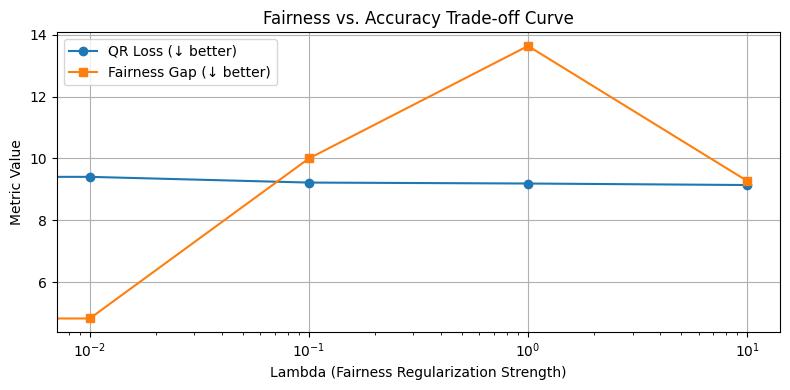

In [34]:
lambda_values = results_df['lambda']
qr_losses = results_df['QR Loss']
fairness_gaps = results_df['Fairness Gap']

plt.figure(figsize=(8, 4))
plt.plot(lambda_values, qr_losses, marker='o', label='QR Loss (↓ better)')
plt.plot(lambda_values, fairness_gaps, marker='s', label='Fairness Gap (↓ better)')
plt.xscale('log')
plt.xlabel('Lambda (Fairness Regularization Strength)')
plt.ylabel('Metric Value')
plt.title('Fairness vs. Accuracy Trade-off Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 기본 모델 학습

In [6]:
def pinball_loss(y_true, y_pred, tau):
    diff = y_true - y_pred
    loss = np.maximum(tau * diff, (tau - 1) * diff)
    return loss.mean()

def group_mean_gap(preds, sens):
    group0 = preds[sens == 0]
    group1 = preds[sens == 1]
    return abs(np.mean(group0) - np.mean(group1))

def residual_gap(preds, targets, sens):
    residuals = targets - preds
    group0 = residuals[sens == 0]
    group1 = residuals[sens == 1]
    return abs(np.mean(group0) - np.mean(group1))

def coverage_gap(preds, targets, sens, tau=0.9):
    cover0 = np.mean(targets[sens == 0] <= preds[sens == 0])
    cover1 = np.mean(targets[sens == 1] <= preds[sens == 1])
    return abs(cover0 - cover1), cover0, cover1

def groupwise_metrics(preds, targets, sens, tau=0.9):
    results = {}

    for group in [0, 1]:
        group_mask = sens == group
        group_preds = preds[group_mask]
        group_targets = targets[group_mask]

        # 평균 예측값
        mean_pred = np.mean(group_preds)
        # 평균 잔차 (실제 - 예측)
        mean_residual = np.mean(group_targets - group_preds)
        # 분위수 커버리지
        coverage = np.mean(group_targets <= group_preds)

        results[group] = {
            'mean_pred': mean_pred,
            'mean_residual': mean_residual,
            'coverage': coverage,
            'count': group_mask.sum()
        }

    return results

In [7]:
def augment_features(x, tau):
    if isinstance(tau, float) or isinstance(tau, int):
        tau_vec = torch.full((x.size(0), 1), float(tau), device=x.device)
    else:
        tau_vec = tau.view(-1, 1)
    return torch.cat([x, tau_vec], dim=1)

def quantile_loss(preds, targets, tau):
    diff = targets - preds
    return torch.mean(torch.max(tau * diff, (tau - 1) * diff))

class GQNN_R(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim + 1, hidden_dim)  # +1 for τ
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x, edge_index, tau):
        x = augment_features(x, tau)  # ← 여기서 τ를 x에 concat
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return self.fc(x).squeeze()

In [8]:
data.num_features

276

In [9]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = GQNN_R(in_dim=data.num_features, hidden_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 1000
data = data.to(device)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # 각 노드에 대해 다른 τ 샘플링 (multi-τ 학습)
    taus = torch.rand(data.x.size(0), 1, device=device)  # [N, 1]
    preds = model(data.x, data.edge_index, taus)

    loss = quantile_loss(preds[data.idx_train], data.y[data.idx_train], taus[data.idx_train])
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            # validation은 하나의 고정된 τ 예로 확인
            tau_val = 0.9
            val_tau = torch.full((data.x.size(0), 1), tau_val, device=device)
            val_preds = model(data.x, data.edge_index, val_tau)
            val_loss = quantile_loss(val_preds[data.idx_val], data.y[data.idx_val], val_tau[data.idx_val])
            print(f"Epoch {epoch:03d}, Train Loss: {loss.item():.4f}, Val Loss (τ={tau_val}): {val_loss.item():.4f}")

Epoch 000, Train Loss: 21.5357, Val Loss (τ=0.9): 37.1453
Epoch 010, Train Loss: 11.4971, Val Loss (τ=0.9): 5.5194
Epoch 020, Train Loss: 9.9920, Val Loss (τ=0.9): 13.9792
Epoch 030, Train Loss: 8.8279, Val Loss (τ=0.9): 9.4431
Epoch 040, Train Loss: 8.5674, Val Loss (τ=0.9): 8.5876
Epoch 050, Train Loss: 8.4153, Val Loss (τ=0.9): 9.0057
Epoch 060, Train Loss: 8.3500, Val Loss (τ=0.9): 8.7572
Epoch 070, Train Loss: 8.2479, Val Loss (τ=0.9): 8.8553
Epoch 080, Train Loss: 8.1640, Val Loss (τ=0.9): 8.9003
Epoch 090, Train Loss: 8.0533, Val Loss (τ=0.9): 8.9295
Epoch 100, Train Loss: 7.9110, Val Loss (τ=0.9): 8.8732
Epoch 110, Train Loss: 7.7346, Val Loss (τ=0.9): 9.2934
Epoch 120, Train Loss: 7.5513, Val Loss (τ=0.9): 8.6952
Epoch 130, Train Loss: 7.3420, Val Loss (τ=0.9): 9.6871
Epoch 140, Train Loss: 7.1746, Val Loss (τ=0.9): 9.8575
Epoch 150, Train Loss: 7.0336, Val Loss (τ=0.9): 9.7322
Epoch 160, Train Loss: 6.8292, Val Loss (τ=0.9): 9.9073
Epoch 170, Train Loss: 6.7465, Val Loss (τ=0

In [10]:
tau_test = 0.9
tau_tensor = torch.full((data.x.size(0), 1), tau_test, device=device)

model.eval()
with torch.no_grad():
    preds = model(data.x, data.edge_index, tau_tensor)[data.idx_test].cpu().numpy()
    targets = data.y[data.idx_test].cpu().numpy()

print(f"Test Pinball Loss (τ={tau_test}): {pinball_loss(targets, preds, tau_test):.4f}")

Test Pinball Loss (τ=0.9): 9.5017


In [12]:
# 테스트셋 민감 속성 값
s_test = data.sensitive_attr[data.idx_test].cpu().numpy()
tau = 0.9

gmg = group_mean_gap(preds, s_test)
rg = residual_gap(preds, targets, s_test)
cg, c0, c1 = coverage_gap(preds, targets, s_test, tau=tau)

print(f"공정성 지표:")
print(f"Group Mean Gap (prediction avg):      {gmg:.4f}")
print(f"Residual Gap (avg error diff):        {rg:.4f}")
print(f"Coverage Gap (P(y ≤ ŷ)):              {cg:.4f}")

print('-' * 60)
results = groupwise_metrics(preds, targets, s_test, tau=tau)

print(f"그룹별 공정성 지표 (τ={tau} 기준)")
for group in results:
    print(f"Group {group} (n={results[group]['count']}):")
    print(f"평균 예측값 : {results[group]['mean_pred']:.4f}")
    print(f"평균 잔차 : {results[group]['mean_residual']:.4f}")
    print(f"분위수 커버리지 : {results[group]['coverage']:.4f}")

공정성 지표:
Group Mean Gap (prediction avg):      0.1419
Residual Gap (avg error diff):        1.6032
Coverage Gap (P(y ≤ ŷ)):              0.0247
------------------------------------------------------------
그룹별 공정성 지표 (τ=0.9 기준)
Group 0 (n=10994):
평균 예측값 : 39.9257
평균 잔차 : 1.9747
분위수 커버리지 : 0.4701
Group 1 (n=5955):
평균 예측값 : 39.7838
평균 잔차 : 3.5779
분위수 커버리지 : 0.4453


In [13]:
tau_list = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
targets = data.y[data.idx_test].cpu().numpy()
sens = data.sensitive_attr[data.idx_test].cpu().numpy()

g0_coverage, g1_coverage, gaps = [], [], []

model.eval()
with torch.no_grad():
    for tau in tau_list:
        # 고정된 τ를 모든 노드에 전달
        tau_tensor = torch.full((data.x.size(0), 1), tau, device=device)
        preds = model(data.x, data.edge_index, tau_tensor)[data.idx_test].cpu().numpy()

        # 그룹 마스크
        mask0 = sens == 0
        mask1 = sens == 1

        # coverage 계산: P(y ≤ ŷ)
        cov_0 = np.mean(targets[mask0] <= preds[mask0])
        cov_1 = np.mean(targets[mask1] <= preds[mask1])
        gap = abs(cov_0 - cov_1)

        g0_coverage.append(cov_0)
        g1_coverage.append(cov_1)
        gaps.append(gap)

print("다양한 분위수에서 Coverage 결과:")
print(" τ     | Group 0  | Group 1  | Gap")
print("-" * 35)
for i, tau in enumerate(tau_list):
    print(f" {tau:<5} | {g0_coverage[i]:.4f}   | {g1_coverage[i]:.4f}   | {gaps[i]:.4f}")

다양한 분위수에서 Coverage 결과:
 τ     | Group 0  | Group 1  | Gap
-----------------------------------
 0.1   | 0.5506   | 0.5382   | 0.0124
 0.25  | 0.5361   | 0.5199   | 0.0162
 0.5   | 0.5108   | 0.4922   | 0.0186
 0.75  | 0.4849   | 0.4638   | 0.0211
 0.9   | 0.4701   | 0.4453   | 0.0247
 0.95  | 0.4643   | 0.4385   | 0.0259
 0.99  | 0.4605   | 0.4336   | 0.0269


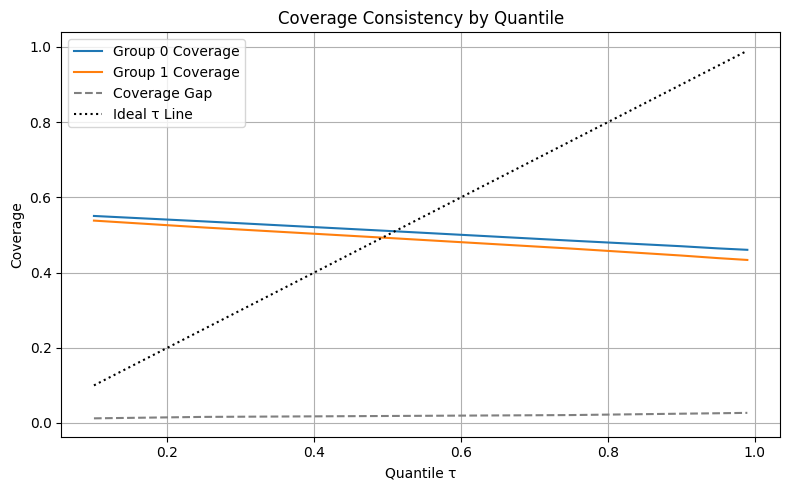

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(tau_list, g0_coverage, label="Group 0 Coverage")
plt.plot(tau_list, g1_coverage, label="Group 1 Coverage")
plt.plot(tau_list, gaps, label="Coverage Gap", linestyle="--", color="gray")
plt.plot(tau_list, tau_list, label="Ideal τ Line", linestyle=":", color="black")

plt.xlabel("Quantile τ")
plt.ylabel("Coverage")
plt.title("Coverage Consistency by Quantile")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()